In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import simulations.sim_prueba1
import soundfile as sf
import pyroomacoustics as pra
from scipy.signal import correlate
from scipy.signal import correlation_lags

In [ ]:


def simular_sala(
    wav_path,
    output_dir,
    sala_dim=(3, 4, 3), 
    rt60=0.4,
    mic_distance=0.1,
    mic_x=1.0,
    mic_z=1.2,
    fuente_distancia=10.0,
    fuente_angulo_deg=45.0,
    fs=16000,
    mic_directivity='omni'
):
    """
    Simula una sala y genera señales recibidas por un array de dos micrófonos.

    Parámetros:
    - wav_path: ruta al archivo .wav anecoico de entrada.
    - output_dir: carpeta donde guardar los archivos de salida.
    - sala_dim: dimensiones (Lx, Ly, Lz) de la sala.
    - rt60: tiempo de reverberación deseado.
    - mic_distance: separación entre micrófonos (m).
    - mic_x, mic_z: posición x y altura fija de los micrófonos.
    - fuente_distancia: distancia desde el centro del array a la fuente (m).
    - fuente_angulo_deg: dirección (azimut) desde la que llega la fuente (grados).
    - fs: frecuencia de muestreo.
    - mic_directivity: tipo de directividad de los micrófonos ('omni', 'cardioid', etc.)

    Retorna:
    - angle_real: ángulo real de llegada en grados.
    - paths: paths de los dos archivos WAV simulados.
    """

    os.makedirs(output_dir, exist_ok=True)

    # Calcular absorción de acuerdo al RT60 deseado
    e_abs, max_order = pra.inverse_sabine(rt60, sala_dim)

    # Crear sala
    sala = pra.ShoeBox(
        sala_dim,
        fs=fs,
        materials=pra.Material(e_abs),
        max_order=max_order
    )

    # Posición del array (en el plano xy)
    mic_y_centro = sala_dim[1] / 2 #consideramos que el mic esta a la mitad de Ly la sala
    mic1 = [mic_x, mic_y_centro - mic_distance / 2, mic_z]
    mic2 = [mic_x, mic_y_centro + mic_distance / 2, mic_z]
    mic_array = np.array([mic1, mic2]).T  # shape (3, N)

    # Agregar micrófonos a la sala
    sala.add_microphone_array(mic_array)

    # Fuente en campo lejano (convertir ángulo a radianes)
    theta = np.radians(fuente_angulo_deg)
    mic_centro = np.mean(mic_array, axis=1)
    fuente_pos = [
        mic_centro[0] + fuente_distancia * np.cos(theta),
        mic_centro[1] + fuente_distancia * np.sin(theta),
        mic_z  # misma altura
    ]

    # Agregar fuente
    sala.add_source(position=fuente_pos, signal=sf.read(wav_path)[0], delay=0)

    # Simulación
    sala.simulate()

    # Guardar audios simulados
    out_paths = []
    for i, signal in enumerate(sala.mic_array.signals):
        filename = f"mic_{i+1}.wav"
        path = os.path.join(output_dir, filename)
        sf.write(path, signal, fs)
        out_paths.append(path)

    # Retornar ángulo real y paths
    return fuente_angulo_deg, out_paths

The desired RT60 was 0.3
The measured RT60 is 0.3691875


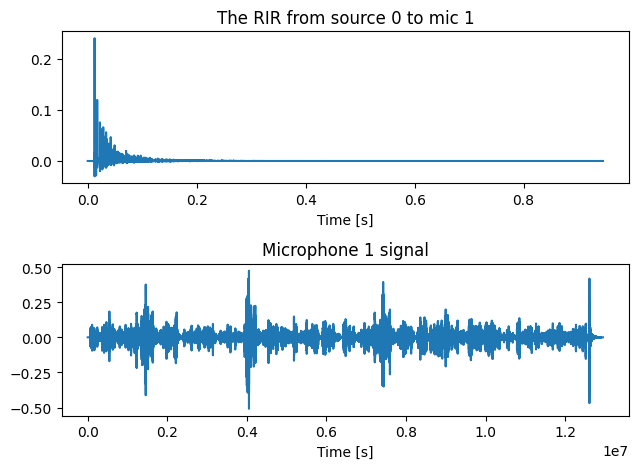

In [ ]:
# The desired reverberation time and dimensions of the room
rt60_tgt = 0.3  # seconds
room_dim = [10, 7.5, 3.5]  # meters

# import a mono sf as the source signal
# the sampling frequency should match that of the room
audio, fs = sf.read("files/anechoic/Flamenco1_U89.wav")

# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order
)

# place the source in the room
room.add_source([2.5, 3.73, 1.76], signal=audio, delay=0.5)

# define the locations of the microphones
mic_locs = np.c_[
    [6.3, 4.87, 1.2], [6.3, 4.93, 1.2],  # mic 1  # mic 2
]

# finally place the array in the room
room.add_microphone_array(mic_locs)

# Run the simulation (this will also build the RIR automatically)
room.simulate()

room.mic_array.to_wav(
    f"files/pyroom_mod/Flamenco1_U89_sim_prueba.wav",
    norm=True,
    bitdepth=np.int16,
)

# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {}".format(rt60_tgt))
print("The measured RT60 is {}".format(rt60[1, 0]))

# Create a plot
plt.figure()

# plot one of the RIR. both can also be plotted using room.plot_rir()
rir_1_0 = room.rir[1][0]
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(rir_1_0)) / room.fs, rir_1_0)
plt.title("The RIR from source 0 to mic 1")
plt.xlabel("Time [s]")

# plot signal at microphone 1
plt.subplot(2, 1, 2)
plt.plot(room.mic_array.signals[1, :])
plt.title("Microphone 1 signal")
plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()

In [10]:
def estimate_doa(audio_file1, audio_file2, mic_distance=0.1, sound_speed=343.0, fs=None):
    """
    Estima el ángulo de arribo (DOA) de una fuente sonora en campo lejano con dos micrófonos.

    Parámetros:
    - audio_file1, audio_file2: rutas a los archivos de audio (wav) grabados por los micrófonos.
    - mic_distance: distancia D entre micrófonos en metros (default 0.1 m).
    - sound_speed: velocidad del sonido en m/s (default 343 m/s).
    - fs: frecuencia de muestreo. Si None, se toma del archivo.

    Retorna:
    - doa_angle_deg: ángulo estimado en grados (respecto al eje del array).
    - tdoa: diferencia de tiempo estimada entre señales (en segundos).
    """

    # Cargar audios
    x1, fs1 = sf.read(audio_file1)
    x2, fs2 = sf.read(audio_file2)

    if fs is None:
        fs = fs1
    assert fs1 == fs2, "Las frecuencias de muestreo deben coincidir."

    # Asegurar igual longitud
    # min_len = min(len(x1), len(x2))
    # x1 = x1[:min_len]
    # x2 = x2[:min_len]

    # Correlación cruzada vía FFT
    corr = correlate(x1, x2, mode='full', method='fft')
    lags = correlation_lags(len(x1), len(x2), mode='full')
    lag_max = lags[np.argmax(corr)]

    # Calcular retardo temporal
    tdoa = lag_max / fs
    # Calcular ángulo
    arg = sound_speed * tdoa / mic_distance
    print(arg)
    if abs(arg) > 1:
        print("Advertencia: valor fuera del dominio de arccos, truncando.")
        arg = np.clip(arg, -1.0, 1.0)

    angle_rad = np.arccos(arg)
    doa_angle_deg = np.degrees(angle_rad)

    return doa_angle_deg, tdoa

In [11]:
estimate_doa('files/archivos_ejc1/piano_cerca.wav',
             'files/archivos_ejc1/piano_lejos.wav',
             mic_distance=120)

-0.9472397569444445


(np.float64(161.30526885427213), np.float64(-0.33139583333333333))